# Kaggle histopathology introduction
This notebook is an introduction to the data challenge of out of distribution classification of histopathology patches. It also serves as a baseline for the code and the model.

If you have any questions, feel free to contact me at [leo.fillioux@centralesupelec.fr](mailto:leo.fillioux@centralesupelec.fr).

In [1]:
import h5py
import torch
import random
import numpy as np
import pandas as pd
import torchmetrics
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader

In [6]:
TRAIN_IMAGES_PATH = 'data/train.h5'
VAL_IMAGES_PATH = 'data/val.h5'
TEST_IMAGES_PATH = 'data/test.h5'
SEED = 0

In [7]:
torch.random.manual_seed(SEED)
random.seed(SEED)

## 1. Introduction to the data
The dataset consists of patches of whole slide images which should be classified into either containing tumor or not. The training images come from 3 different centers (i.e. hospitals), while the validation set comes from another center and the test set from yet another center. The visual aspect of the patches are quite different due to the slightly different staining procedures, conditions, and equipment from each hospital. The objective of the task is to build a classifier that is impacted by this distribution shift as little as possible.

The data is stored in `.h5` files, which can be seen as a folder hierarchy, which are can be seen as the following.
```
├── idx           # index of the image
│   └── img       # image in a tensor format
│   └── label     # binary label of the image
│   └── metadata  # some metadata on the images
```
The metadata is included for completeness but is not necessarily useful. The first element in the metadata corresponds to the center.

The following is a visualization of how different the images look from the different centers.

In [8]:
train_images = {0: {0: None, 1: None},
                3: {0: None, 1: None},
                4: {0: None, 1: None}}
val_images = {1: {0: None, 1: None}}

In [9]:
for img_data, data_path in zip([train_images, val_images], [TRAIN_IMAGES_PATH, VAL_IMAGES_PATH]):
    with h5py.File(data_path, 'r') as hdf:
        for img_idx in list(hdf.keys()):
            label = int(np.array(hdf.get(img_idx).get('label')))
            center = int(np.array(hdf.get(img_idx).get('metadata'))[0])
            if img_data[center][label] is None:
                img_data[center][label] = np.array(hdf.get(img_idx).get('img'))
            if all(all(value is not None for value in inner_dict.values()) for inner_dict in img_data.values()):
                break
all_data = {**train_images, **val_images}

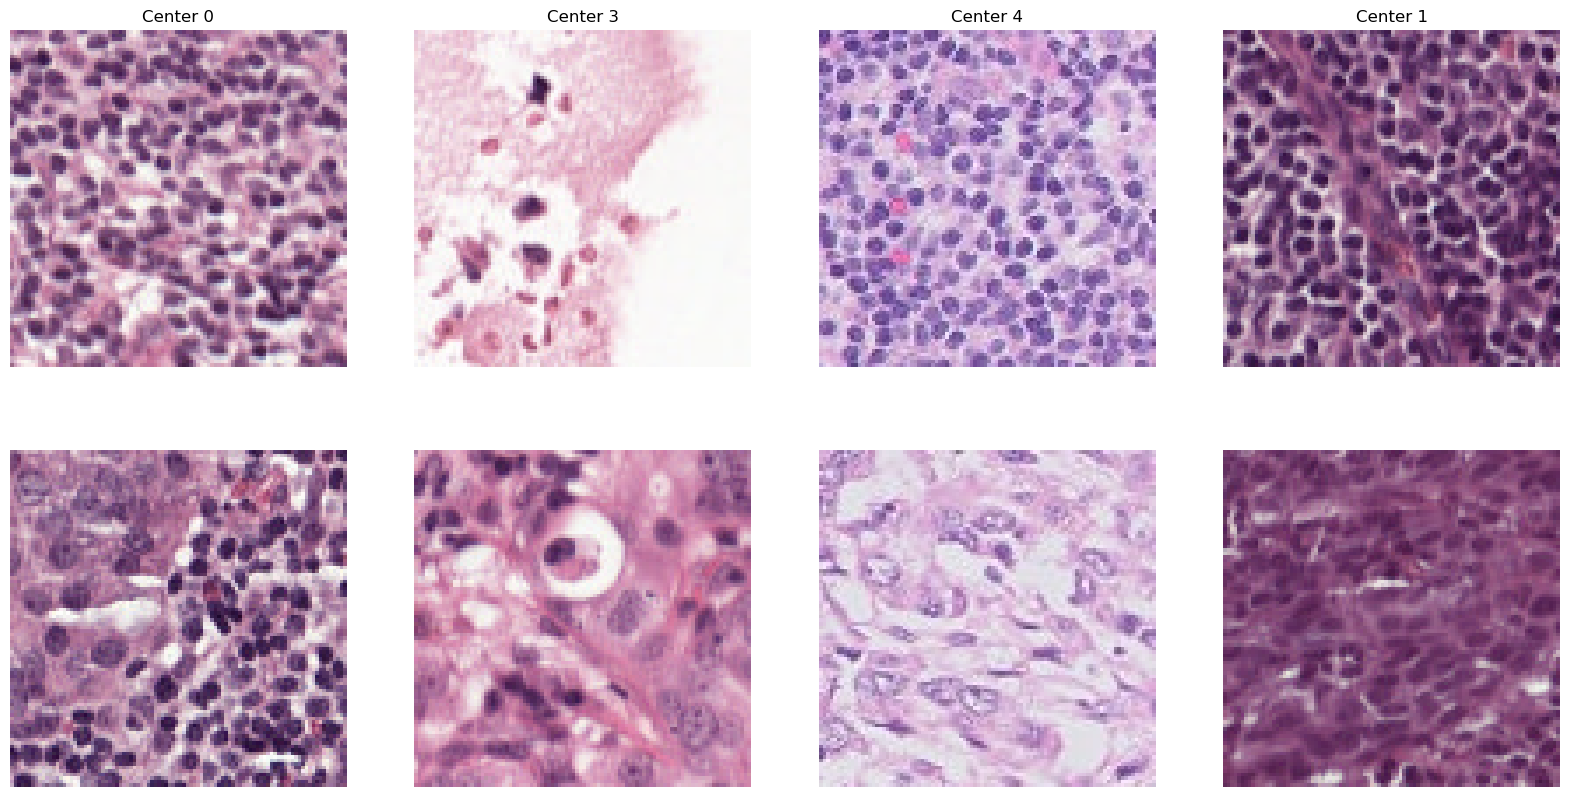

In [12]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
center_ids = {center: idx for idx, center in enumerate(all_data.keys())}
for center in all_data:
    for label in all_data[center]:
        axs[label, center_ids[center]].imshow(np.moveaxis(all_data[center][label], 0, -1).astype(np.float32))
        axs[label, center_ids[center]].axis('off')
        if label == 0:
            axs[label, center_ids[center]].set_title(f'Center {center}')
plt.show()

## 2. Building a baseline model
The baseline model consists of extracting DINOv2 embeddings and linear probing.

In [43]:
BATCH_SIZE = 16

### 2.1. Baseline dataset
We start by creating the model to read and process the data. For this simple model we also use another dataset with the preprocessed embeddings to avoid recomputing the same embeddings each time.

In [44]:
class BaselineDataset(Dataset):
    def __init__(self, dataset_path, preprocessing, mode):
        super(BaselineDataset, self).__init__()
        self.dataset_path = dataset_path
        self.preprocessing = preprocessing
        self.mode = mode
        
        with h5py.File(self.dataset_path, 'r') as hdf:        
            self.image_ids = list(hdf.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        with h5py.File(self.dataset_path, 'r') as hdf:
            img = torch.tensor(hdf.get(img_id).get('img'))
            label = np.array(hdf.get(img_id).get('label')) if self.mode == 'train' else None
        return self.preprocessing(img).float(), label

In [45]:
def precompute(dataloader, model, device):
    xs, ys = [], []
    for x, y in tqdm(dataloader, leave=False):
        with torch.no_grad():
            xs.append(model(x.to(device)).detach().cpu().numpy())
        ys.append(y.numpy())
    xs = np.vstack(xs)
    ys = np.hstack(ys)
    return torch.tensor(xs), torch.tensor(ys)

In [46]:
class PrecomputedDataset(Dataset):
    def __init__(self, features, labels):
        super(PrecomputedDataset, self).__init__()
        self.features = features
        self.labels = labels.unsqueeze(-1)
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx].float()

In [47]:
preprocessing = transforms.Resize((98, 98))
train_dataset = BaselineDataset(TRAIN_IMAGES_PATH, preprocessing, 'train')
val_dataset = BaselineDataset(VAL_IMAGES_PATH, preprocessing, 'train')

In [48]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)

### 2.2. Building the models and precomputing the features

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Working on {device}.')

Working on cpu.


In [50]:
feature_extractor = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)
feature_extractor.eval()
linear_probing = torch.nn.Sequential(torch.nn.Linear(feature_extractor.num_features, 1),
                                     torch.nn.Sigmoid()).to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /Users/paulcaucheteux/.cache/torch/hub/main.zip
/Users/paulcaucheteux/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/paulcaucheteux/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/paulcaucheteux/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /Users/paulcaucheteux/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:02<00:00, 38.3MB/s]


In [51]:
train_dataset = PrecomputedDataset(*precompute(train_dataloader, feature_extractor, device))
val_dataset = PrecomputedDataset(*precompute(val_dataloader, feature_extractor, device))

  0%|          | 0/6250 [00:00<?, ?it/s]

/var/folders/bt/7p2n2htn2jx9_bcbhdzps_gm0000gp/T/ipykernel_56380/1650232611.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  img = torch.tensor(hdf.get(img_id).get('img'))


KeyboardInterrupt: 

In [16]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)

## 3. Training the model

In [17]:
OPTIMIZER = 'Adam'
OPTIMIZER_PARAMS = {'lr': 0.001}
LOSS = 'BCELoss'
METRIC = 'Accuracy'
NUM_EPOCHS = 100
PATIENCE = 10

In [18]:
optimizer = getattr(torch.optim, OPTIMIZER)(linear_probing.parameters(), **OPTIMIZER_PARAMS)
criterion = getattr(torch.nn, LOSS)()
metric = getattr(torchmetrics, METRIC)('binary')
min_loss, best_epoch = float('inf'), 0

In [19]:
for epoch in range(NUM_EPOCHS):
    linear_probing.train()
    train_metrics, train_losses = [], []
    for train_x, train_y in tqdm(train_dataloader, leave=False):
        optimizer.zero_grad()
        train_pred = linear_probing(train_x.to(device))
        loss = criterion(train_pred, train_y.to(device))
        loss.backward()
        optimizer.step()
        train_losses.extend([loss.item()]*len(train_y))
        train_metric = metric(train_pred.cpu(), train_y.int().cpu())
        train_metrics.extend([train_metric.item()]*len(train_y))
    print(f'Epoch train [{epoch+1}/{NUM_EPOCHS}] | Loss {np.mean(train_losses):.4f} | Metric {np.mean(train_metrics):.4f}')

    linear_probing.eval()
    val_metrics, val_losses = [], []
    for val_x, val_y in tqdm(val_dataloader, leave=False):
        with torch.no_grad():
            val_pred = linear_probing(val_x.to(device))
        loss = criterion(val_pred, val_y.to(device))
        val_losses.extend([loss.item()]*len(val_y))
        val_metric = metric(val_pred.cpu(), val_y.int().cpu())
        val_metrics.extend([val_metric.item()]*len(val_y))
    print(f'Epoch valid [{epoch+1}/{NUM_EPOCHS}] | Loss {np.mean(val_losses):.4f} | Metric {np.mean(val_metrics):.4f}')

    if np.mean(val_losses) < min_loss:
        mean_val_loss = np.mean(val_losses)
        print(f'New best loss {min_loss:.4f} -> {mean_val_loss:.4f}')
        min_loss = mean_val_loss
        best_epoch = epoch
        torch.save(linear_probing.state_dict(), 'best_model.pth')

    if epoch - best_epoch == PATIENCE:
        break

  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [1/100] | Loss 0.1759 | Metric 0.9331


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [1/100] | Loss 0.3392 | Metric 0.8584
New best loss inf -> 0.3392


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [2/100] | Loss 0.1551 | Metric 0.9415


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [2/100] | Loss 0.3700 | Metric 0.8543


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [3/100] | Loss 0.1506 | Metric 0.9435


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [3/100] | Loss 0.3396 | Metric 0.8626


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [4/100] | Loss 0.1481 | Metric 0.9444


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [4/100] | Loss 0.3574 | Metric 0.8626


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [5/100] | Loss 0.1472 | Metric 0.9445


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [5/100] | Loss 0.3248 | Metric 0.8706
New best loss 0.3392 -> 0.3248


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [6/100] | Loss 0.1454 | Metric 0.9459


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [6/100] | Loss 0.3279 | Metric 0.8742


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [7/100] | Loss 0.1446 | Metric 0.9457


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [7/100] | Loss 0.3619 | Metric 0.8643


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [8/100] | Loss 0.1446 | Metric 0.9458


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [8/100] | Loss 0.3741 | Metric 0.8612


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [9/100] | Loss 0.1445 | Metric 0.9458


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [9/100] | Loss 0.3524 | Metric 0.8668


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [10/100] | Loss 0.1439 | Metric 0.9462


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [10/100] | Loss 0.3956 | Metric 0.8500


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [11/100] | Loss 0.1437 | Metric 0.9462


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [11/100] | Loss 0.3128 | Metric 0.8786
New best loss 0.3248 -> 0.3128


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [12/100] | Loss 0.1438 | Metric 0.9465


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [12/100] | Loss 0.3371 | Metric 0.8744


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [13/100] | Loss 0.1421 | Metric 0.9466


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [13/100] | Loss 0.3473 | Metric 0.8707


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [14/100] | Loss 0.1428 | Metric 0.9470


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [14/100] | Loss 0.3405 | Metric 0.8720


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [15/100] | Loss 0.1436 | Metric 0.9461


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [15/100] | Loss 0.3406 | Metric 0.8657


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [16/100] | Loss 0.1424 | Metric 0.9473


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [16/100] | Loss 0.3429 | Metric 0.8730


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [17/100] | Loss 0.1425 | Metric 0.9467


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [17/100] | Loss 0.3589 | Metric 0.8698


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [18/100] | Loss 0.1422 | Metric 0.9470


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [18/100] | Loss 0.3176 | Metric 0.8782


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [19/100] | Loss 0.1431 | Metric 0.9466


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [19/100] | Loss 0.3470 | Metric 0.8709


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [20/100] | Loss 0.1435 | Metric 0.9467


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [20/100] | Loss 0.3122 | Metric 0.8809
New best loss 0.3128 -> 0.3122


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [21/100] | Loss 0.1430 | Metric 0.9466


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [21/100] | Loss 0.3466 | Metric 0.8698


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [22/100] | Loss 0.1423 | Metric 0.9465


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [22/100] | Loss 0.3355 | Metric 0.8726


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [23/100] | Loss 0.1419 | Metric 0.9475


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [23/100] | Loss 0.3313 | Metric 0.8731


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [24/100] | Loss 0.1420 | Metric 0.9468


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [24/100] | Loss 0.3296 | Metric 0.8801


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [25/100] | Loss 0.1418 | Metric 0.9475


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [25/100] | Loss 0.3178 | Metric 0.8780


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [26/100] | Loss 0.1430 | Metric 0.9468


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [26/100] | Loss 0.3324 | Metric 0.8711


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [27/100] | Loss 0.1427 | Metric 0.9461


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [27/100] | Loss 0.3186 | Metric 0.8774


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [28/100] | Loss 0.1425 | Metric 0.9475


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [28/100] | Loss 0.4484 | Metric 0.8364


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [29/100] | Loss 0.1420 | Metric 0.9470


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [29/100] | Loss 0.3287 | Metric 0.8778


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [30/100] | Loss 0.1422 | Metric 0.9469


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [30/100] | Loss 0.3383 | Metric 0.8745


## 4. Making the final prediction

To create a solutions file, you need to generate a CSV with 2 columns.
- **ID**: containing the ID of the image
- **Pred**: with the predicted class (**threshold the prediction to get either 0 or 1**)

In [20]:
linear_probing.load_state_dict(torch.load('best_model.pth', weights_only=True))
linear_probing.eval()
linear_probing.to(device)
prediction_dict = {}

In [21]:
with h5py.File(TEST_IMAGES_PATH, 'r') as hdf:
    test_ids = list(hdf.keys())

In [25]:
solutions_data = {'ID': [], 'Pred': []}
with h5py.File(TEST_IMAGES_PATH, 'r') as hdf:
    for test_id in tqdm(test_ids):
        img = preprocessing(torch.tensor(np.array(hdf.get(test_id).get('img')))).unsqueeze(0).float()
        pred = linear_probing(feature_extractor(img.to(device))).detach().cpu()
        solutions_data['ID'].append(int(test_id))
        solutions_data['Pred'].append(int(pred.item() > 0.5))
solutions_data = pd.DataFrame(solutions_data).set_index('ID')
solutions_data.to_csv('baseline.csv')

  0%|          | 0/85054 [00:00<?, ?it/s]